https://www.kaggle.com/competitions/goodreads-books-reviews-290312/overview

https://towardsdatascience.com/productive-nlp-experimentation-with-python-using-pytorch-lightning-and-torchtext-256a4d00a26b

https://www.kaggle.com/code/xceptions/text-classification-with-pytorch/notebook

https://www.kaggle.com/code/swarnabha/pytorch-text-classification-torchtext-lstm/notebook

https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

https://stackabuse.com/text-classification-with-python-and-scikit-learn/

https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

https://lightning-transformers.readthedocs.io/en/latest/tasks/nlp/text_classification.html

https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

https://github.com/ricardorei/lightning-text-classification

### Import libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

### Importing and analyzing the datasets


In [8]:
goodreads_train = pd.read_csv("data/goodreads_train.csv") 
goodreads_test = pd.read_csv("data/goodreads_test.csv")

In [9]:
goodreads_test.shape

(478033, 10)

In [10]:
goodreads_train.shape 

(900000, 11)

In [11]:
goodreads_train.sample(5)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
389740,66a47aaaec778f689ad05248110c7b6c,53496,f1e6d82109c9ad960fd13ddcb96d7fc8,0,1995 Newbery Medal Winner,Wed Feb 17 14:39:39 -0800 2010,Tue Aug 23 09:09:38 -0700 2011,NaN,NaN,0,0
893058,7eb88583ca5e58150e0e02c369ff3b28,6076380,bab82c0cfd3cfcbf9138a090816f389e,4,"Before I say anything, I wish to first warn re...",Thu Oct 18 14:41:18 -0700 2012,Sun Mar 03 22:50:44 -0800 2013,Sun Mar 03 00:00:00 -0800 2013,NaN,16,0
287739,3e4eb82e9eddfa819b48495e73064902,26795865,dbd5def70a6f758d35e2adb042e68529,5,Ok. If you liked the first book on Jo and Juli...,Mon Oct 12 22:25:57 -0700 2015,Thu Feb 11 04:04:37 -0800 2016,Fri Oct 09 00:00:00 -0700 2015,NaN,1,0
239491,5c8e42118841e8b09d964f9700a57abb,9067850,e3acd4006d798ef15cd2dde12cf3af02,3,Spoilers \n So we start off with the new chara...,Wed Apr 03 16:22:22 -0700 2013,Sat Sep 28 06:53:57 -0700 2013,Sun Apr 14 00:00:00 -0700 2013,Wed Apr 03 00:00:00 -0700 2013,0,1
461538,0f58075fb2be4b61bf8a1d3cf10f29ea,15839976,40e46b454c0f15e7a66238029ea7d4d3,5,This was a bloody damn good book! I really hop...,Sat Jan 02 21:29:21 -0800 2016,Wed Jan 06 21:48:58 -0800 2016,Wed Jan 06 00:00:00 -0800 2016,Sat Jan 02 00:00:00 -0800 2016,0,0


In [12]:
goodreads_train.set_index("review_id", inplace=True)
goodreads_test.set_index("review_id", inplace=True)

Concating the train and test sets to EDA

In [13]:
books = pd.concat([goodreads_train.drop('rating', axis=1), goodreads_test], axis=0)
books_rates = goodreads_train['rating']
books.shape

(1378033, 9)

In [14]:
books.sample(5)

,user_id,book_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
review_id,,,,,,,,,
109c97dc504e489ca707e4e17ffabbbe,3da4eb15ef07eed078def91e0b1fc800,7557790,Favorite scene from the book I thought it was ...,Wed Feb 18 19:22:10 -0800 2015,Sat Feb 21 14:27:10 -0800 2015,Sat Feb 21 14:27:10 -0800 2015,Wed Feb 18 00:00:00 -0800 2015,0,0
ec1e86505a7efb736d4682fd838dce30,c0e0fda388f87af0deffad748c9c8b67,16704759,A wonderful continuation to Lucian and Sophie'...,Fri Dec 21 13:17:25 -0800 2012,Sat May 04 17:44:34 -0700 2013,Sat May 04 00:00:00 -0700 2013,Sat May 04 00:00:00 -0700 2013,1,0
0a3e0382878ad4f564a722759466f92e,dd6e21b7659b3cb2333ad536bc145bb4,23228,3.5 \n I'm not sure how to rate this. I enjoye...,Thu Jul 07 10:49:43 -0700 2016,Fri Jul 08 15:48:01 -0700 2016,Fri Jul 08 15:48:01 -0700 2016,Thu Jul 07 00:00:00 -0700 2016,0,0
eb216ef7ea73a8cfa31168c8ee407dda,32bbebf74fa8c3191fa57526e7f62b04,25667474,THE FEELS ARE STRONG,Sun Oct 23 18:59:45 -0700 2016,Sat Aug 05 13:23:39 -0700 2017,Mon Jul 31 13:39:42 -0700 2017,Sat Jul 29 00:00:00 -0700 2017,1,0
adc4318b89fc178c32d056a8d1c81a3e,748cd2cd9b0aaea09168e83dedd3666d,10428229,Frustrating....,Thu Jun 20 06:33:09 -0700 2013,Fri Feb 13 05:41:48 -0800 2015,Mon Sep 16 03:02:24 -0700 2013,NaN,0,0


### EDA

In [15]:
# import tensorflow_data_validation as tfdv

In [16]:
# books_stats = tfdv.generate_statistics_from_dataframe(books)

In [17]:
# tfdv.visualize_statistics(books_stats)

In [18]:
# Droping some non-essential columns
books.drop(columns=['date_updated', 'read_at', 'started_at'], axis=1, inplace=True)

In [19]:
# Removing rows with negative n_votes or negative n_comments 
books = books[(books['n_votes'] >= 0) & (books['n_comments'] >= 0)]

In [20]:
# Checking duplications

sum(books.duplicated())

0

In [21]:
sum(books.duplicated(subset=['review_text']))

16130

In [22]:
books.drop_duplicates(subset=['review_text'], inplace=True)

In [23]:
# Finding unappropriate texts
unapp_texts = books['review_text'].apply(lambda txt: np.mean(list(map(len, txt.split())))) > 25


In [24]:
books[unapp_texts].shape

(26, 6)

In [25]:
books[unapp_texts]

,user_id,book_id,review_text,date_added,n_votes,n_comments
review_id,,,,,,
ba7e149d70cb858d87d4113dfe0e4091,8092e33e9c50d3e269a8164177d2abdc,6339664,IhavetoadmitihavefalleninlovewithPatcicannotwa...,Sun Sep 30 12:29:48 -0700 2012,1,1
90529a603506931b91502b3c65b0564c,308c545182f8b5d332ff71c667fd9b61,12127810,the feels for NICO DI ANGELO.....................,Thu May 16 23:11:00 -0700 2013,0,0
7105506d7aa373be892e6d7d29750741,302eb3debfc02e0bdd0fd617d34a2713,10644930,"""The past is obdurate."" \n rtcrtcrtcrtcrtcrtcr...",Fri Mar 18 07:59:13 -0700 2016,0,0
ba4e577524730630bef88cb4c76c6dd7,de107a99cb0ed2ec5d90d744cc48c310,23723788,2.5 it's-a-good-book-as-in-even-after-months-I...,Sun Aug 30 18:18:44 -0700 2015,0,0
d9d104943954cc9d975a07d1a724be90,de107a99cb0ed2ec5d90d744cc48c310,23496782,2.5 It-Was-a-Very-Okay-Book-With-the-Mystery-a...,Thu Apr 09 04:41:42 -0700 2015,3,0
a79de0fe1d6b8cb32722276577a2a870,ba0a0f32ee81d2bc56866f4ab767062c,7664041,Must...fry...more...brain...cells!,Mon Nov 14 14:58:55 -0800 2011,0,0
ebb2dc04593320cf2e6af799a0f98e63,1ffb13e4f8c151bb07c8d8eb869c2d7e,18630598,#certaincharactersthatiwontdisclosedeservedbet...,Sun Jul 09 16:46:56 -0700 2017,0,0
59fa84dcdaa951b79ef0bb4bcda2d19d,f65170af6d65deb8d2c3dbfc0fe79939,13562356,Aw.That.Was.Nice.And.Too.Short.,Tue Mar 11 10:37:14 -0700 2014,1,0
4955188c74fbc2f4da1cbf4a1bb452e1,27325d8a3c87ccb35bc603e158c35dd3,25558608,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Thu Feb 11 12:36:49 -0800 2016,1,0


In [26]:
more_than_2_dot = r'\.{2,}'
books['review_text'].replace(more_than_2_dot, ' ', inplace=True, regex=True)

In [27]:
unapp_texts = books['review_text'].apply(lambda txt: np.mean(list(map(len, txt.split())))) > 25

In [28]:
books[unapp_texts].head()

,user_id,book_id,review_text,date_added,n_votes,n_comments
review_id,,,,,,
ba7e149d70cb858d87d4113dfe0e4091,8092e33e9c50d3e269a8164177d2abdc,6339664,IhavetoadmitihavefalleninlovewithPatcicannotwa...,Sun Sep 30 12:29:48 -0700 2012,1,1
7105506d7aa373be892e6d7d29750741,302eb3debfc02e0bdd0fd617d34a2713,10644930,"""The past is obdurate."" \n rtcrtcrtcrtcrtcrtcr...",Fri Mar 18 07:59:13 -0700 2016,0,0
ba4e577524730630bef88cb4c76c6dd7,de107a99cb0ed2ec5d90d744cc48c310,23723788,2.5 it's-a-good-book-as-in-even-after-months-I...,Sun Aug 30 18:18:44 -0700 2015,0,0
d9d104943954cc9d975a07d1a724be90,de107a99cb0ed2ec5d90d744cc48c310,23496782,2.5 It-Was-a-Very-Okay-Book-With-the-Mystery-a...,Thu Apr 09 04:41:42 -0700 2015,3,0
ebb2dc04593320cf2e6af799a0f98e63,1ffb13e4f8c151bb07c8d8eb869c2d7e,18630598,#certaincharactersthatiwontdisclosedeservedbet...,Sun Jul 09 16:46:56 -0700 2017,0,0


In [29]:
books.drop(books[unapp_texts].index, axis=0, inplace=True)

In [30]:
spoil_statement = 'spoiler alert'
books['spoil'] = [True if spoil_statement in txt else False for txt in books['review_text']]

In [31]:
books[books['spoil'] == True]

,user_id,book_id,review_text,date_added,n_votes,n_comments,spoil
review_id,,,,,,,
e23965adda7ce7e7e415a1339e169065,8842281e1d1347389f2ab93d60773d4d,62291,** spoiler alert ** \n Loved it. The epic saga...,Tue Jul 12 12:57:07 -0700 2011,5,1,True
0258b3c9a85cecb95f240e43a7642f60,8842281e1d1347389f2ab93d60773d4d,7112495,** spoiler alert ** \n An interesting book in ...,Thu Jun 10 14:41:13 -0700 2010,7,3,True
d44b6d28f456dbcc5b1537b4c5572400,8842281e1d1347389f2ab93d60773d4d,6411961,"** spoiler alert ** \n Critics aside, Dan Brow...",Wed Sep 16 11:09:03 -0700 2009,3,3,True
d49eb786ef1d8557b9e6e86bcafd4570,8842281e1d1347389f2ab93d60773d4d,77432,"** spoiler alert ** \n I equally loved book 2,...",Tue May 05 18:08:22 -0700 2009,1,0,True
b8e08587ce1592d69548d0f644cb9893,8842281e1d1347389f2ab93d60773d4d,14497,** spoiler alert ** \n Just finished this and ...,Thu Mar 27 17:53:06 -0700 2008,6,1,True
...,...,...,...,...,...,...,...
a989c818917a7463089454b356fb6671,5ff0927d425ab1a70d2b2d41fe6b96b5,13239950,** spoiler alert ** \n Hills like White Elepha...,Wed Oct 31 18:22:50 -0700 2012,25,7,True
3736d5ee5904b4b5651912dd28b7ce01,a16fd6b48c6e877042acbe2bda8a0007,115076,** spoiler alert ** \n I was completely engros...,Mon Jun 04 07:18:34 -0700 2012,0,0,True
a7777a1c18ab582586a61ad453d91949,692ce8eb4d5490980f6e74f6cb8671e2,12974372,** spoiler alert ** \n Hmm what to say about t...,Wed Nov 04 12:33:22 -0800 2015,1,0,True


* converting all letters to lower or upper case
* converting numbers into words or removing numbers
* removing punctuations, accent marks and other diacritics
* removing white spaces
* expanding abbreviations
* removing stop words, sparse terms, and particular words
* text canonicalization

In [32]:
# Converting all charecters to lower case
books['review_text'] = books['review_text'].str.lower()

In [33]:
# Removing numbers
# books['review_text'].replace(r'\d+', '', inplace=True, regex=True)

In [34]:
import re
import string
ss = pd.Series(['  RegExr was created by    gskinner.com, and is proudly    .  hosted by Media Temple. . . '])

# exclist = string.punctuation + string.digits
repl = lambda pat: ' ' if((' ' in pat.group()) and (pat.span()[0] != 0)) else ''

# repl = lambda pat: print(pat.group())

ss.str.replace(r'[^\w\s]|\d+|\s{2,}|^\s', repl, regex=True).str.strip()[0]

# ' ' in 'fg '

# re.sub(r'\s{2,}', '', re.sub(r'\W|\d+', ' ', ss))

'RegExr was created by gskinnercom and is proudly  hosted by Media Temple'

In [35]:
# Removing punctuation

## Way 1
import string
exclist = string.punctuation + string.digits
def remove_punc_num(txt):
    return ' '.join(txt.translate(str.maketrans(exclist, ' '*len(exclist))).split())

books['review_text'] = books['review_text'].apply(remove_punc_num)


## Way 2
# books['review_text'] = books['review_text'].str.replace(r'[^\w\s]|\d+','', regex=True)



In [36]:
books['review_text']

review_id
dfdbb7b0eb5a7e4c26d59a937e2e5feb    this is a special book it started slow for abo...
a5d2c3628987712d0e05c4f90798eb67    recommended by don katz avail for free in dece...
2ede853b14dc4583f96cf5d120af636f    a fun fast paced science fiction thriller i re...
ced5675e55cd9d38a524743f5c40996e    recommended reading to understand what is goin...
332732725863131279a8e345b63ac33e    i really enjoyed this book and there is a lot ...
                                                          ...                        
0e1db3d4b04256f9660f5d276ddf1314    can t wait for travis pov travis before abby t...
0b7f352e58caf0fd1f961e98ef04e89c    had this on my to read shelf forever will upda...
9b19eff33ddb14e9e68fca2e90379e46    the last book left me wanting for more i need ...
8be463fed78f0da63e964706f710332b    things are heating up in the second novel of i...
62ed1263c7d216986cc419cd4e8a408b    before i even start this review i must say tha...
Name: review_text, Length: 1361779, dtype: o

In [37]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [38]:
## Downloading NLTK data
#nltk.download()

In [39]:
stopwords_list = stopwords.words('english')

In [60]:
lamitizer = WordNetLemmatizer()

def remove_sw_tokenize(txt):
    tokenized_txt = txt.split(" ")
    clean_txt = [lamitizer.lemmatize(word) for word in tokenized_txt if word not in stopwords_list]

    return clean_txt

In [51]:
books['review_text_tokens'] = books['review_text'].progress_apply(remove_sw_tokenize)

100%|██████████| 1361779/1361779 [29:28<00:00, 769.94it/s] 


In [52]:
books.sample(4)

,user_id,book_id,review_text,date_added,n_votes,n_comments,spoil,review_text_tokens
review_id,,,,,,,,
dfdbb7b0eb5a7e4c26d59a937e2e5feb,8842281e1d1347389f2ab93d60773d4d,18245960,this is a special book it started slow for abo...,Sun Jul 30 07:44:10 -0700 2017,28,1,False,"[special, book, started, slow, first, third, m..."
a5d2c3628987712d0e05c4f90798eb67,8842281e1d1347389f2ab93d60773d4d,16981,recommended by don katz avail for free in dece...,Mon Dec 05 10:46:44 -0800 2016,1,0,False,"[recommended, katz, avail, free, december, htt..."
2ede853b14dc4583f96cf5d120af636f,8842281e1d1347389f2ab93d60773d4d,28684704,a fun fast paced science fiction thriller i re...,Tue Nov 15 11:29:22 -0800 2016,22,0,False,"[fun, fast, paced, science, fiction, thriller,..."
ced5675e55cd9d38a524743f5c40996e,8842281e1d1347389f2ab93d60773d4d,27161156,recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,5,1,False,"[recommended, reading, understand, going, midd..."
332732725863131279a8e345b63ac33e,8842281e1d1347389f2ab93d60773d4d,25884323,i really enjoyed this book and there is a lot ...,Mon Apr 25 09:31:23 -0700 2016,9,1,False,"[really, enjoyed, book, lot, recommend, drag, ..."


In [ ]:
books.to_csv('data/cleaned_concated_books.csv')

In [ ]:
clean_books = pd.read_csv('data/cleaned_concated_books.csv', index_col=False)
clean_books.set_index('review_id', inplace=True)

datetime_format = '%a %b %d %H:%M:%S %z %Y'
clean_books['date_added'] = pd.to_datetime(clean_books['date_added'], format=datetime_format, utc=True)

clean_books.sample(5)

,user_id,book_id,review_text,date_added,n_votes,n_comments,spoil
review_id,,,,,,,
b6c5ee623cf317c760057de74c5c33ed,147e931b6109d16af66b63a798ec8f7f,23666139,"i found it slow going at first, and i admit i ...",2015-05-21 15:28:19+00:00,9,3,False
6f43683c17c88fd2946166b9fb366ff8,360b333e9c48ac442165a0f9b7728dd1,18285151,anyone that says they're having a bad day shou...,2015-04-15 10:26:09+00:00,0,0,False
d62af9b6d6fc422f2443f76ac908ead9,c497ceb0273befafb3e44545fb6da098,2,like. obviously 5/5. forgot how much i love th...,2013-08-11 15:32:54+00:00,0,0,False
a72b7fd5aec15426c749b58d55764ded,bdbb67054b647860f48ab2406e31bb26,57893,this manga is not that different from the orig...,2013-08-01 17:41:52+00:00,0,0,False
70fbb50d5cfe0df3297361b6dd8d6849,1e9698f39e8a69db0f93ffc7133c3fb6,23846013,"4 stars! \n * \n once upon a time, a girl had ...",2016-02-07 20:15:11+00:00,0,0,False


In [ ]:
clean_books.shape

(1361779, 7)

In [ ]:
clean_books.describe()

,book_id,n_votes,n_comments
count,1.361779e+06,1.361779e+06,1.361779e+06
mean,1.335799e+07,3.120326e+00,9.494007e-01
std,9.260324e+06,1.709191e+01,5.420550e+00
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,6.393834e+06,0.000000e+00,0.000000e+00
50%,1.336157e+07,0.000000e+00,0.000000e+00
75%,2.029968e+07,2.000000e+00,0.000000e+00
max,3.632868e+07,3.222000e+03,1.335000e+03


In [ ]:
type(books['date_added'][0])

str

<AxesSubplot:title={'center':'10 Date with most reviews'}, xlabel='Dates', ylabel='Count'>

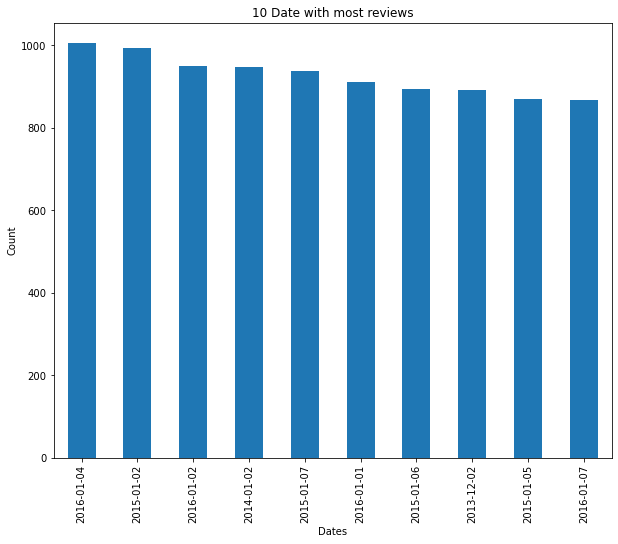

In [ ]:
books_dates_added = clean_books['date_added'].dt.date
books_dates_added.value_counts()[:10].plot(kind='bar', 
                                            figsize=(10, 8),
                                            title='10 Date with most reviews',
                                            xlabel='Dates',
                                            ylabel='Count')

AttributeError: Can only use .dt accessor with datetimelike values

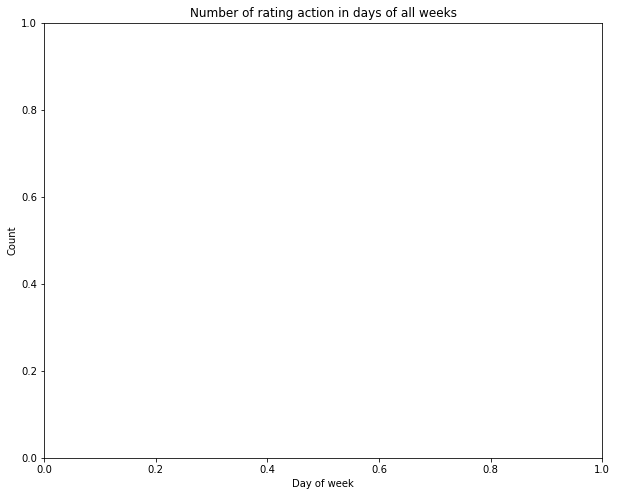

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Number of rating action in days of all weeks")
plt.xlabel("Day of week")
plt.ylabel("Count")
sns.histplot(books['date_added'].dt.day_name())

<AxesSubplot:title={'center':'Number of rating action in months of all years'}, xlabel='Month of week', ylabel='Count'>

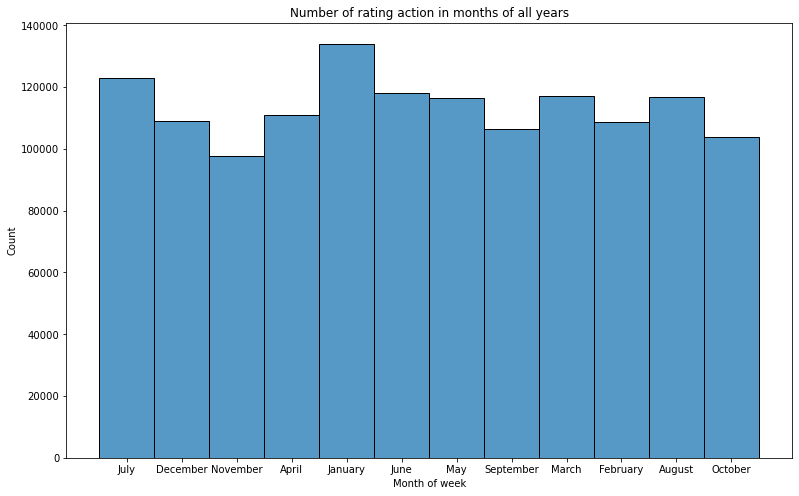

In [ ]:
plt.figure(figsize=(13, 8))
plt.title("Number of rating action in months of all years")
plt.xlabel("Month of week")
plt.ylabel("Count")
sns.histplot(books['date_added'].dt.month_name())


<AxesSubplot:title={'center':'10 books with the most reviews'}, xlabel='Book id', ylabel='Number of reviews'>

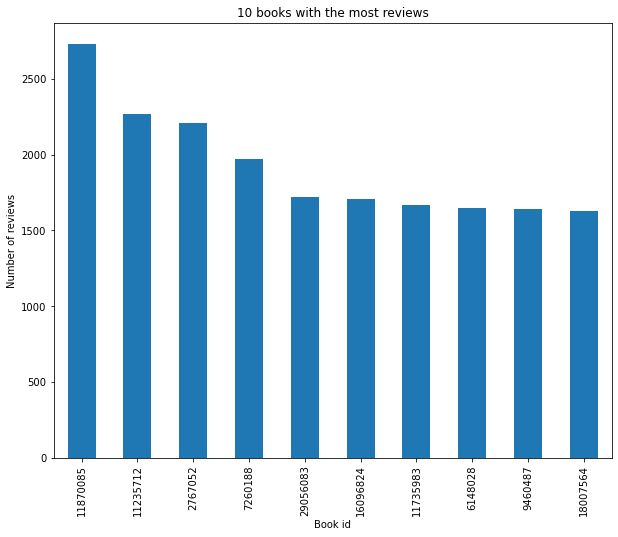

In [ ]:
books.groupby('book_id').count().sort_values(by='user_id', ascending=False)['user_id'][:10].plot(kind='bar', 
                                                                                                    figsize=(10, 8),
                                                                                                    title='10 books with the most reviews',
                                                                                                    xlabel='Book id',
                                                                                                    ylabel='Number of reviews')

<AxesSubplot:title={'center':'10 users with the most reviews'}, xlabel='User id', ylabel='Number of reviews'>

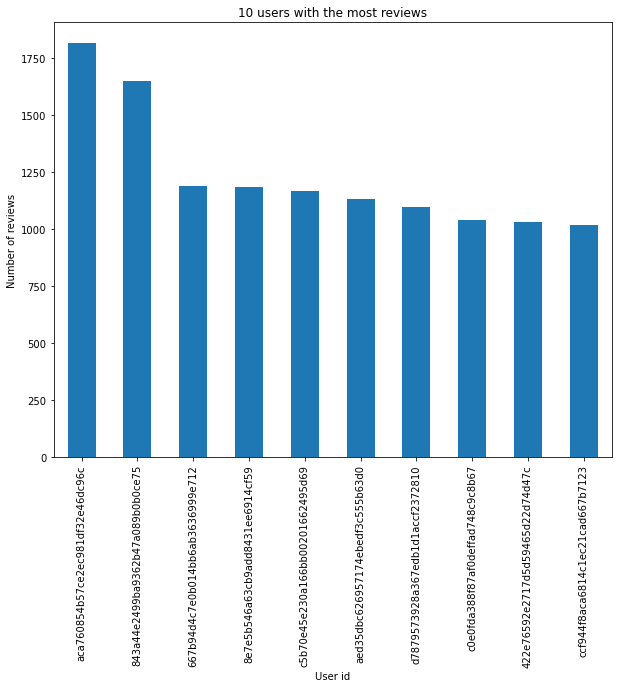

In [ ]:
books.groupby('user_id').count().sort_values(by='book_id', ascending=False)['book_id'][:10].plot(kind='bar',
                                                                                                    figsize=(10, 8),
                                                                                                    title='10 users with the most reviews',
                                                                                                    xlabel='User id',
                                                                                                    ylabel='Number of reviews')

<AxesSubplot:title={'center':'Number of Spoilers Vs. NO Spoilers'}, xlabel='Tags', ylabel='Count'>

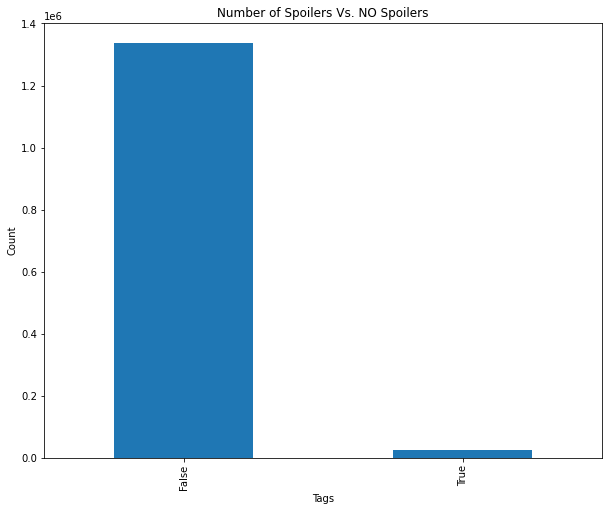

In [ ]:
books['spoil'].value_counts().plot(kind='bar', 
                                    figsize=(10, 8),
                                    title='Number of Spoilers Vs. NO Spoilers',
                                    xlabel='Tags',
                                    ylabel='Count')

In [ ]:
books_rates = goodreads_train['rating']
books_rates.head()

review_id
dfdbb7b0eb5a7e4c26d59a937e2e5feb    5
a5d2c3628987712d0e05c4f90798eb67    3
2ede853b14dc4583f96cf5d120af636f    3
ced5675e55cd9d38a524743f5c40996e    0
332732725863131279a8e345b63ac33e    4
Name: rating, dtype: int64

In [ ]:
cleaned_books = books.merge(books_rates, how='inner', on='review_id')
cleaned_books

,user_id,book_id,review_text,date_added,n_votes,n_comments,spoil,rating
review_id,,,,,,,,
dfdbb7b0eb5a7e4c26d59a937e2e5feb,8842281e1d1347389f2ab93d60773d4d,18245960,This is a special book. It started slow for ab...,2017-07-30 14:44:10+00:00,28,1,False,5
a5d2c3628987712d0e05c4f90798eb67,8842281e1d1347389f2ab93d60773d4d,16981,Recommended by Don Katz. Avail for free in Dec...,2016-12-05 18:46:44+00:00,1,0,False,3
2ede853b14dc4583f96cf5d120af636f,8842281e1d1347389f2ab93d60773d4d,28684704,"A fun, fast paced science fiction thriller. I ...",2016-11-15 19:29:22+00:00,22,0,False,3
ced5675e55cd9d38a524743f5c40996e,8842281e1d1347389f2ab93d60773d4d,27161156,Recommended reading to understand what is goin...,2016-11-10 01:37:04+00:00,5,1,False,0
332732725863131279a8e345b63ac33e,8842281e1d1347389f2ab93d60773d4d,25884323,"I really enjoyed this book, and there is a lot...",2016-04-25 16:31:23+00:00,9,1,False,4
...,...,...,...,...,...,...,...,...
7c34c15ad8cb28a4afca32946e2016ea,b9450d1c1f97f891c392b1105959b56e,11832081,3.5 stars. \n Jenna is a popular YA author and...,2012-11-17 06:10:17+00:00,0,0,False,3
e979c735276431915d089cfaf446d64f,b9450d1c1f97f891c392b1105959b56e,16095092,This was a quick read for me. I have read a lo...,2012-11-17 06:09:49+00:00,1,1,False,3
feb9fe6439f9fbba8a1cce36020ad977,b9450d1c1f97f891c392b1105959b56e,8430896,** spoiler alert ** \n 3.5 stars. \n This book...,2012-11-13 13:38:24+00:00,1,0,True,4


<AxesSubplot:title={'center':'The Number of each rate'}, xlabel='Rate', ylabel='Count'>

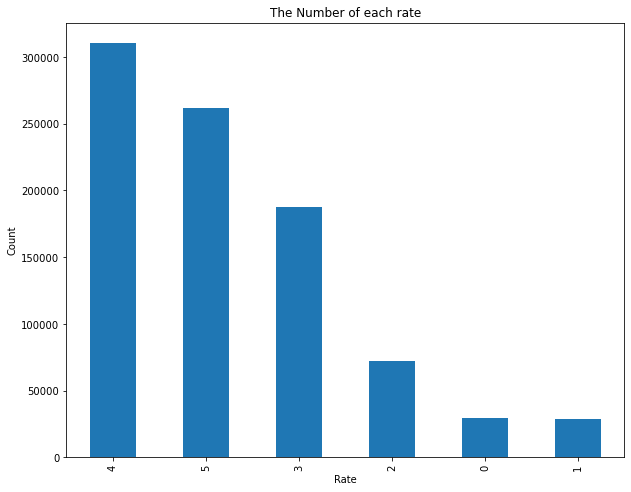

In [ ]:
cleaned_books['rating'].value_counts().plot(kind='bar', 
                                        figsize=(10, 8),
                                        title='The Number of each rate',
                                        xlabel='Rate',
                                        ylabel='Count')

C:\Users\amoosi\AppData\Local\Temp\ipykernel_244\3115209394.py:1: FutureWarning: ['user_id', 'review_text', 'date_added'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  rates_by_books = cleaned_books.groupby(by='book_id').agg([np.mean, np.std])['rating'].plot(kind='hist',


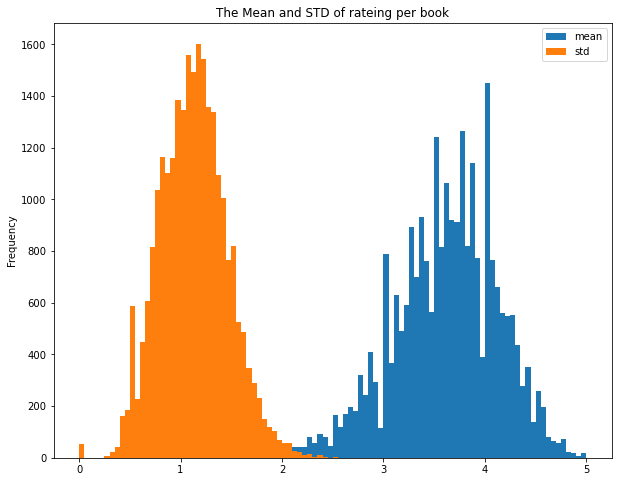

In [ ]:
rates_by_books = cleaned_books.groupby(by='book_id').agg([np.mean, np.std])['rating'].plot(kind='hist', 
                                                                                        figsize=(10, 8),
                                                                                        title='The Mean and STD of rateing per book',
                                                                                        xlabel='Value',
                                                                                        bins=100, 
                                                                                        legend=True)

## Machine learning models

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

## Pytorch model

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger('tb_logs', name='my_model')

In [ ]:
tensorboard --logdir tb_logs/